# Exploring US Wages Across Occupations
### By Sarah Schmidt



<img src="people-in-uniform-doing-different-occupations_1308-1835.jpg">




In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import itertools
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC

%matplotlib inline

In [14]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"


## Our data is reported median wages for men and women for different occupations. 



In [15]:
genderwage = pd.read_csv(datafile)
genderwage.head(1)

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726


### Others have already asked "IS there a wage gap?" and "How big is the wage gap?"  I wanted to ask a different question. 

### My question is can we predict Occupation Category using wage, gender, share of females in the field, and if that field is male dominated or has a significant wage gap?

In [16]:
genderwage.count()

Occupation     558
All_workers    558
All_weekly     558
M_workers      558
M_weekly       558
F_workers      558
F_weekly       558
dtype: int64

In [17]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [18]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [19]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [20]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

## Uncovering occupation categories and assigning labels to rows

In [21]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

genderwage.insert(1, 'Occupation_Category', 0)

cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index,
                    genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index,
                        genderwage.columns.get_loc('Occupation_Category')] = cat_count

genderwage.insert(1, 'Occupation_Category_label', 0)

cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index,
                    genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index,
                        genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

In [22]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any').copy()
cleanedgenderwage = cleanedgenderwage.loc[~cleanedgenderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [23]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
PRODUCTION                 11
SALES                      11
COMPUTATIONAL               7
HEALTHCARE PROFESSIONAL     7
CULINARY                    7
EDUCATION                   4
TRANSPORTATION              4
SCIENCE                     3
SERVICE                     3
SOCIAL SERVICE              3
PROTECTIVE SERVICE          3
ARTS                        3
GROUNDSKEEPING              3
ENGINEERING                 2
LEGAL                       1
HEALTHCARE SUPPORT          1
AGRICULTURAL                1
Name: Occupation_Category_label, dtype: int64

## Combining occupation labels to facilitate modeling

In [24]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE PROFESSIONAL', 'Occupation_Category_label'] = 'HEALTHCARE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'GROUNDSKEEPING', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'TRANSPORTATION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'EDUCATION', 'Occupation_Category_label'] = 'SOCIAL SERVICE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'PROTECTIVE SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ARTS', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ENGINEERING', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SCIENCE', 'Occupation_Category_label'] = 'OTHER'


In [25]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                    17
MANAGEMENT                16
OTHER                     15
BUSINESS                  12
SALES                     11
PRODUCTION                11
INFRASTRUCTURE SUPPORT     8
HEALTHCARE                 8
CULINARY                   7
SOCIAL SERVICE             7
COMPUTATIONAL              7
Name: Occupation_Category_label, dtype: int64

# Distribution of Employees

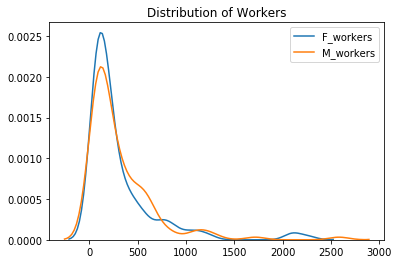

In [45]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.title('Distribution of Workers')
plt.show()

# Next the distribution of wages

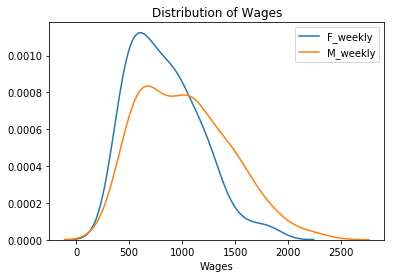

In [27]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.title('Distribution of Wages')
plt.xlabel('Wages')
plt.show()

# Mens and Womens wages by field wages

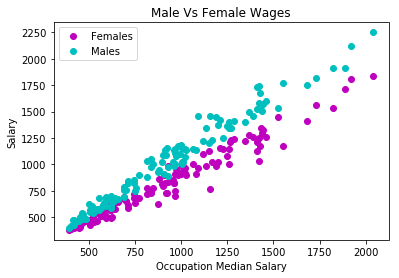

In [28]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'],
         cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'],
         cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.title('Male Vs Female Wages')
plt.ylabel('Salary')
plt.show()

### New features from old



In [29]:
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']
cleanedgenderwage['Male_Dominated'] = np.where(cleanedgenderwage['F_share'] > .45, 0, 1)


# Kernel Density Estimate Plot
# for the Wage Ratio

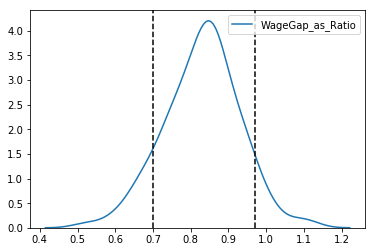

In [54]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])
plt.axvline(x=.7, color='black', linestyle='--')
plt.axvline(x=.97, color='black', linestyle='--') 
plt.show()

# Female Share per Occupation

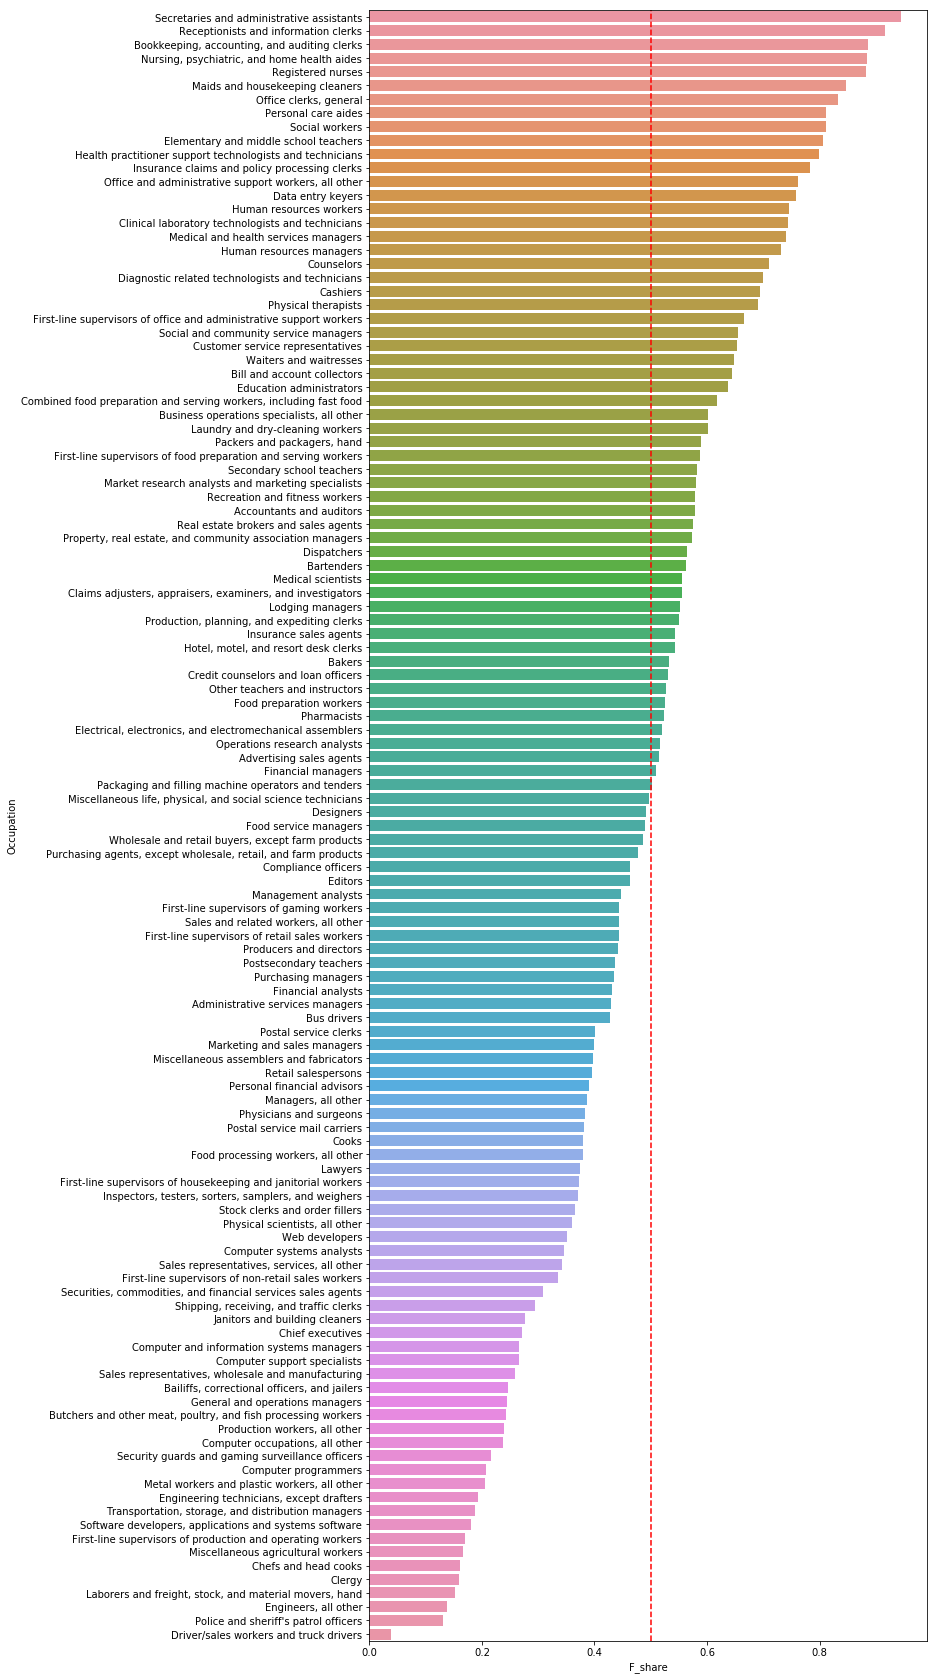

In [50]:

# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='F_share',
            y='Occupation',
            data=cleanedgenderwage.sort_values('F_share', ascending=False))
plt.axvline(x=.5, color='red', linestyle='--') # equality at 50%
plt.show()

# Wage Ratio By Occupation

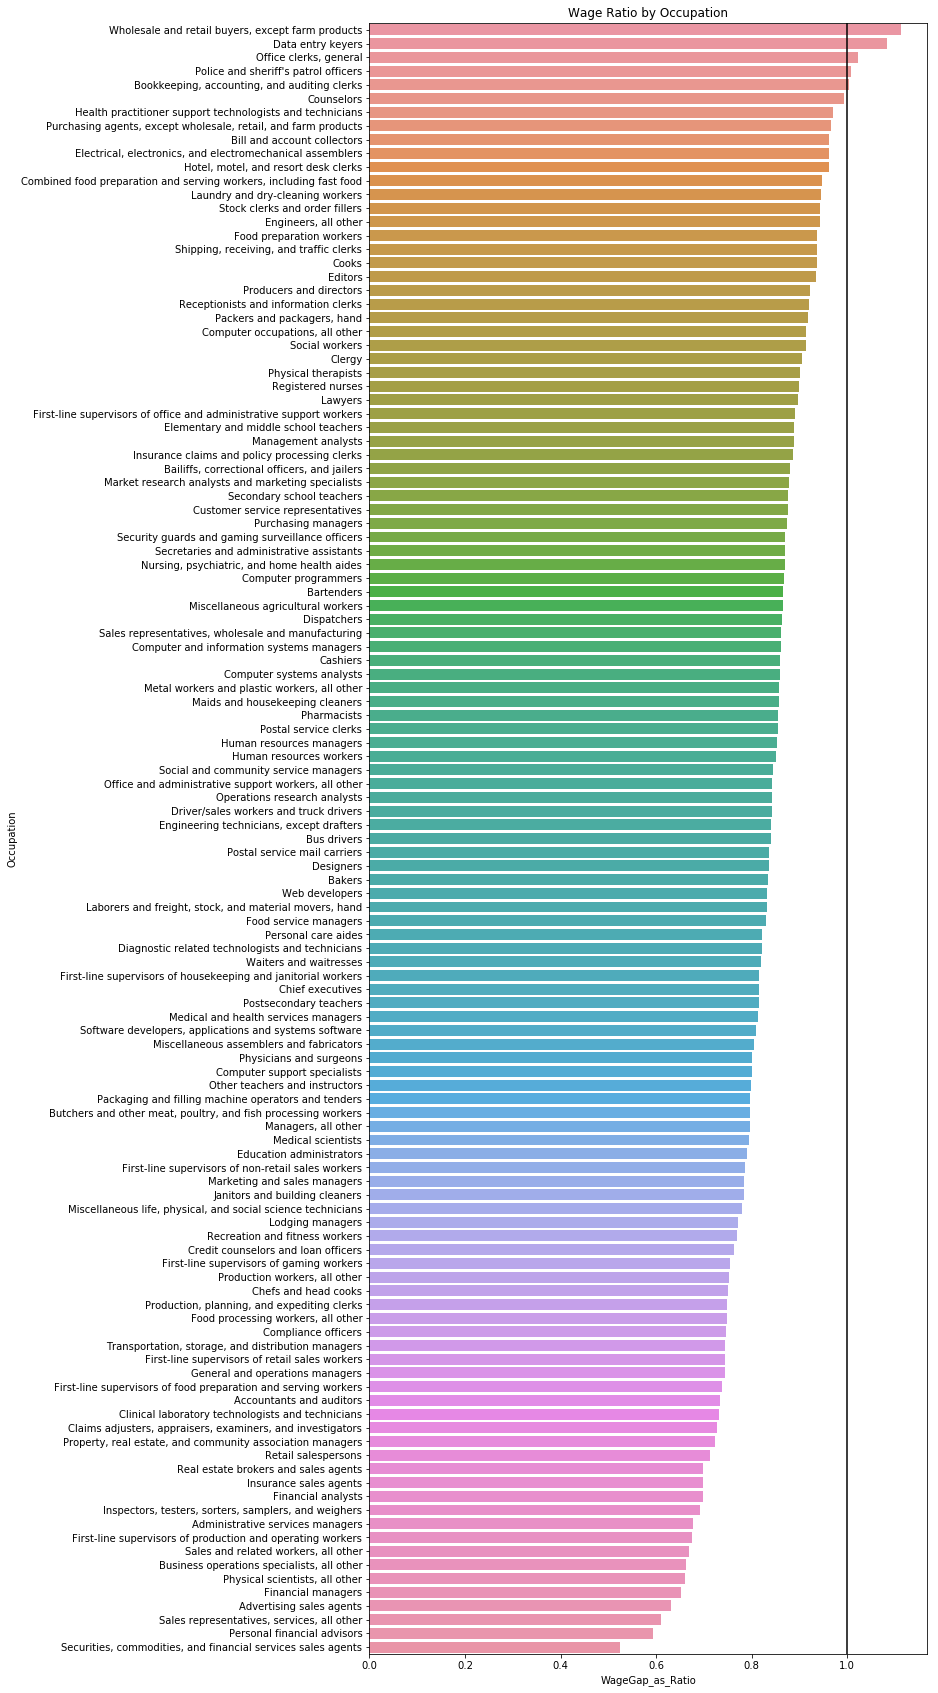

In [32]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio',
                                               ascending=False))
plt.axvline(x=1, color='black', linestyle='solid')
plt.title('Wage Ratio by Occupation')
plt.show()

# Modeling the Data




The question I'm asking is a classification question, so I tested:
    - Logistic Regression Classifier  (A Classic first step classifier)
    - Decision Tree Classifier (a different kind of classifier than a regression)
    - Random Forest Classifier (multiple decision trees together as a classifier)
    - Extra Trees Ensemble Classifier (more trees might be better)
    - Support Vector Classifier (a third kind of classifier)
    - Gradient Boosting Classifier (a  fourth kind of classifier)


In [33]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3, ratio='auto', kind='regular')

## Assign our variables, scale our X, use SMOTE to expand our training data

In [34]:
scaler = StandardScaler()
columns = ['M_weekly',
           'F_weekly',
           'Male_Dominated',
           'Significant_wage_gap',
           'WageGap_as_Ratio',
           'F_share']

X = cleanedgenderwage[columns]

X_std = StandardScaler().fit_transform(X)
y = cleanedgenderwage['Occupation_Category_label']

X_train, X_test, y_train, y_test = train_test_split(X_std,
                                                    y,
                                                    test_size=.4,
                                                    random_state=64)
# using random state so I can rerun cells 
# and not accidentally change the number of instances in my classes

X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [35]:
y_test.value_counts()

MANAGEMENT                7
OFFICE                    6
PRODUCTION                6
BUSINESS                  5
SALES                     4
HEALTHCARE                4
OTHER                     4
CULINARY                  3
INFRASTRUCTURE SUPPORT    3
COMPUTATIONAL             3
SOCIAL SERVICE            3
Name: Occupation_Category_label, dtype: int64

## I wrote a small function so that I could use GridSearchCV to check multiple estimators without having to manually set each one up. 

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    return (grid_classifier, grid_score)

## Create the dictionary of each estimators parameters to check, set up the different estimators, set up list of estimators and list of params.

In [37]:
log_param = {'tol': (.01, .5, 1, 5),
             'C': (.01, .5, 1, 5),
             'solver': ('newton-cg', 'lbfgs', 'sag')}
forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
dtree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}
svc_param = {'C': (.1, .5, 1, 5),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'degree': (2, 3, 4, 5),
             'gamma': (1, 2, 3)}

# got my estimators
logr = linear_model.LogisticRegression()
gradient = ensemble.GradientBoostingClassifier()
extree = ensemble.ExtraTreesClassifier()
dtree = tree.DecisionTreeClassifier()
svc = SVC()
forest = ensemble.RandomForestClassifier()

estimators = [logr,
              gradient,
              extree,
              dtree,
              svc,
              forest]
params = [log_param,
          gradient_param,
          forest_type_param,
          dtree_param,
          svc_param,
          forest_type_param]


## Iterate over both lists, using function to check each estimator and its corresponding list of parameters.

In [76]:
results = []

for estimator, param in list(zip(estimators, params)):
        best_estimator, grid_score = check_grid(estimator, param, X_smote, y_smote)
        y_pred = best_estimator.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append((best_estimator, accuracy))
    

print(results)

[(GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tol': (0.01, 0.5, 1, 5), 'C': (0.01, 0.5, 1, 5), 'solver': ('newton-cg', 'lbfgs', 'sag')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 0.2916666666666667), (GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_frac

# The confusion matrix of our best scoring model

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


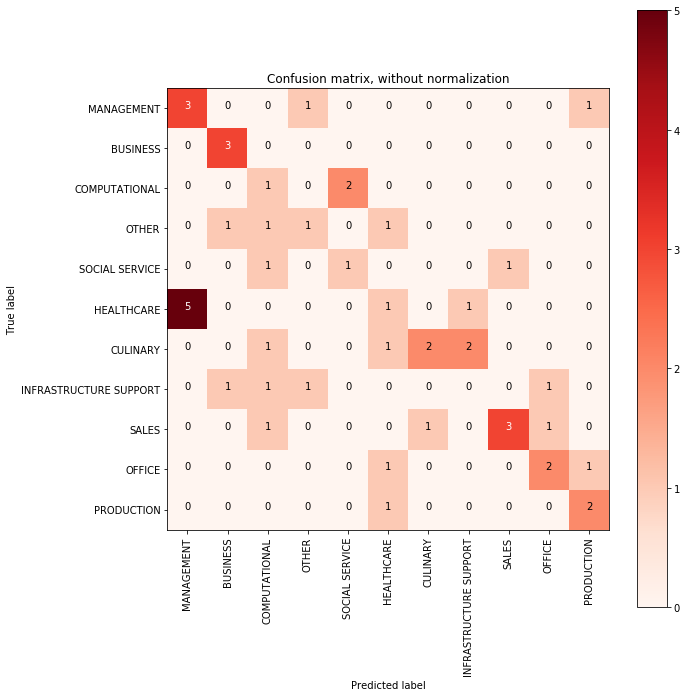

In [79]:
# look at confusion matrix here

bestModel = results[-1][0]
y_pred = bestModel.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = cleanedgenderwage['Occupation_Category_label'].unique()

plt.figure(figsize=(10, 10))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Conclusions

Random chance gives each of our 11 labels an equally likely 9% chance if we just guess. The poorest performing model still returned a score above 45%. 

# Next steps go here